In [1]:
from __future__ import print_function, division, absolute_import

import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=20"

import jax.numpy as np
from numpy.random import choice
import numpy as onp
from jax import grad, jit, vmap, jacobian, jacfwd, jacrev, hessian, pmap
from jax import random
from jax.scipy.special import logsumexp
from jax.example_libraries import optimizers
from jax.tree_util import tree_map
import time
from IPython.display import clear_output
from matplotlib import pyplot as plt
import itertools
from matplotlib import animation
from IPython.display import HTML
from IPython.display import display, Image
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator
import json

import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", True)

import matplotlib.gridspec as gridspec

from scipy.signal import savgol_filter
from scipy import integrate
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

from collections import OrderedDict

from jax.nn import swish, tanh

SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

left  = 0.05  # the left side of the subplots of the figure
right = 0.925    # the right side of the subplots of the figure
bottom = 0.15   # the bottom of the subplots of the figure
top = 0.85      # the top of the subplots of the figure
wspace = 0.25   # the amount of width reserved for blank space between subplots
hspace = 0.25   # the amount of height reserved for white space between subplots

## Data preprocessing

In [3]:
# Single-pulse, only pulse 0 is used
pulse_train = [0]
pulse_train = [str(p) for p in pulse_train]

f = open('../../data/TAP_thin_data.json')
thin_data = json.load(f)
f.close()
thin_data = json.loads(thin_data)['1']

n_species = 0

y_train = []
t_train = []

for j, k in enumerate(thin_data):
    if k == 'time':
        for i in thin_data[k].keys():
            t_temp = thin_data[k][i][14:40:1]
            t_temp += thin_data[k][i][40:100:3]
            t_temp += thin_data[k][i][100:300:5]
            t_temp += thin_data[k][i][300::30]
            if i in pulse_train:
                t_train.extend(np.array(t_temp))
                
        t_train = np.log(np.array([t_train]).T)

    elif k == 'Ar':
        continue
    
    else:
        y_temp_train = []
        for i in thin_data[k].keys():
            y_temp_i = []
            if i in pulse_train:
                y_temp_i = thin_data[k][i][14:40:1] + thin_data[k][i][40:100:3] + thin_data[k][i][100:300:5] + thin_data[k][i][300::30]
                y_temp_train += list(y_temp_i)

        y_train.append(np.array(y_temp_train))

n_species = int(j) - 1
total_species = n_species

# Scale to range 0 to 1
y_train = onp.array(y_train)
y_train_scale = np.max(y_train, axis = 1)

conc_inv = (y_train.T/y_train_scale, t_train)

In [6]:
n_latent = 3

def read_flux(file_name, p_train):
    
    f_path = file_name
    f = open(f_path)
    flux_data = json.load(f)
    f.close()
    flux_data = json.loads(flux_data)['1']
    
    y_train = []
    for j, k in enumerate(flux_data):
        if k == 'time':
            continue
        elif k == 'Ar':
            continue
        else:
            y_temp_train = []
            for i in flux_data[k].keys():
                if i in p_train:
                    y_temp_train += flux_data[k][i][14:40:1]
                    y_temp_train += flux_data[k][i][40:100:3]
                    y_temp_train += flux_data[k][i][100:300:5]
                    y_temp_train += flux_data[k][i][300::30]
            y_train.append(np.array(y_temp_train))
            
    for i in range(n_latent):
        y_train.append(np.zeros(len(t_train)))
    
    y_train = np.array(y_train).T
        
    return y_train

flux_in_train = read_flux('../../data/TAP_cat_in.json', pulse_train)
flux_out_train = read_flux('../../data/TAP_cat_out.json', pulse_train)

L_thin = 0.17364

net_flux_train = ((flux_in_train - flux_out_train)/L_thin)
data_inv = (np.concatenate((conc_inv[0], net_flux_train), axis = -1), conc_inv[-1])

In [8]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_model_params(m, key, scale=1e-2):
    return (scale * random.normal(key, (m,)))

def init_network_params(sizes, key, scale):
    '''
    Initialize all layers for a fully-connected neural network with sizes "sizes"
    '''
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k, scale) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

def init_model_params(size, key, scale):
    '''
    Initialize kinetic model with size "size"
    '''
    key = random.split(key,2)[-1] 
    return [random_model_params(s, key, scale) for s in size]

@jit
def act_fun(x):
    return tanh(x)
    
@jit
def state(params, t):
    activations = t
    for w, b in params[:-1]:
        outputs = np.dot(w, activations) + b
        activations = act_fun(outputs)
    
    final_w, final_b = params[-1]
    y = (np.dot(final_w, activations) + final_b)
    return y

# Make a batched version of the `state` function
batched_state = vmap(state, in_axes=(None,0))

@jit
def diff_state(params,t):
    '''
    Backpropogation through jacobian
    '''
    i = np.arange(len(t))
    return np.nan_to_num(jacfwd(lambda t : batched_state(params,t))(t)[i,:,i,0])
    
def loss(get_errors, params, batch, flux):
    return np.array([_.mean() for _ in get_errors(params,batch, flux)]).sum()

def train(params,data,ferrors,loss,num_epochs,num_iter,opt_objs,err_tags,batch_size=None):
    opt_state, opt_update, get_params, iter_data = opt_objs
   
    @jit
    def step(data, params):
        batch = [_[:,:total_species] for _ in data]
        flux = data[0][:, total_species:]       
        grads = grad(lambda ferrors, params, batch, flux :np.nan_to_num(loss(ferrors, params, batch, flux))\
                     ,argnums=1)(ferrors, params, batch, flux)
        return grads
    
    step_parallel = pmap(step, in_axes = (0, None))
    
    def mean_map(grad):
        return tree_map(lambda x: x.mean(axis = 0), grad)
    mean_fn = jit(mean_map)
    
    @jit
    def update(itercount, grads, opt_state):
        return opt_update(itercount, grads, opt_state)
        
    itercount = itertools.count()        
    if not batch_size:
        batch_size = data[0].shape[0]
    
    # Reshape for parallel data distribution over 20 processors
    data_parallel = (data[0].reshape(20,-1,total_species*2), data_inv[1].reshape(20,-1,1))
    iter_data += [get_params(opt_state).copy()]
    for j in range(num_epochs):
        clear_output(wait=True)
#         sel = random.shuffle(random.PRNGKey(j),np.arange(data[0].shape[0])) # uncomment if random shuffle
        
        for i in range(int(num_iter)):
            params = get_params(opt_state)
            
            grads_parallel = step_parallel(data_parallel, params)
            grads = mean_fn(grads_parallel)
            
            opt_state = update(next(itercount), grads, opt_state)
        
        batch = [_[:,:total_species] for _ in data]
        flux = data[0][:, total_species:]
    
        params = get_params(opt_state) 
        loss_it_batch = loss(ferrors, params, batch, flux)

        errs = [_.sum() for _ in ferrors(params,batch, flux)]

        print('Epoch: {:4d}, Loss Batch: {:.5e}'.format(j, loss_it_batch)+\
                  ''.join([', Fit {}: {:.5e}'.format(_,__) for _,__ in zip(err_tags,errs)]))
        print(params[-1])
        iter_data += [params.copy()]
    
    return params, [opt_state, opt_update, get_params, iter_data]

In [172]:
@jit
def errors_inv(params, batch, flux):
    '''
    Total loss as the combine of data loss and model loss
    '''
    x, t = batch
    NA = np.array(flux)
    nn_params, model_params = params
    pred_x = batched_state(nn_params,t)
    err_data = ((pred_x-x)**2).mean(axis=1)
    
    # Chain rule
    err_model = ((diff_state(nn_params,t) / np.exp(t[:,0:1]) - batched_model([pred_x,t],model_params,NA) / y_train_scale)**2).sum(axis=1)
    
    return [err_data, err_model]

In [9]:
@jit
def model(batch, model_params, flux):
    '''
    Define the ODE kinetic model
    '''
    x, t = batch
    k,  = model_params
    k, x = [np.abs(_) for _ in [k,x]]
    x = x * y_train_scale
    return np.array(np.array([[-k[0]*x[0]*x[5] + k[1]*x[3] - k[5]*x[0]*x[4]],
                    [-k[2]*x[1]*x[5]**2],
                    [k[3]*x[3]*x[4] - k[4]*x[2]*x[5]**2 + k[5]*x[0]*x[4]],
                    [k[0]*x[0]*x[5] - k[1]*x[3] - k[3]*x[3]*x[4] + k[4]*x[2]*x[5]**2],
                    [(k[2]*x[1]*x[5]**2)*2 - k[3]*x[3]*x[4] + k[4]*x[2]*x[5]**2 - k[5]*x[0]*x[4]],
                    [-k[0]*x[0]*x[5] + k[1]*x[3] - (k[2]*x[1]*x[5]**2)*2 + k[3]*x[3]*x[4]*2 - 2*k[4]*x[2]*x[5]**2 + k[5]*x[0]*x[4]]]) + 
                    onp.reshape(flux, (6,1)))

batched_model = lambda batch, model_params, flux : vmap(model,in_axes=(0,None,0))(batch,model_params,flux)[:,:,0]#, in_axes=(None, 0)

In [120]:
layer_sizes = [1, 8, 6] # inputs, hidden..., output layes
model_size = [6]
key = random.PRNGKey(0)

nn_scale = 0.01 # weights scales
model_scale = 0.00001 # model scale (assume low so as not to eb bias)

nn_params = init_network_params(layer_sizes, key, nn_scale)
model_params = init_model_params(model_size, key, model_scale)
params = [nn_params, model_params] #pack


opt_inv = optimizers.adam(1e-3, b1=0.9, b2=0.9999, eps=1e-100)
opt_inv = (opt_inv[0](params), opt_inv[1], opt_inv[2], [])

In [173]:
%%time
err_tags = ['Data','Model']
num_epochs = 1000
num_iter = 10
batch_size = None

for i in range(10):
    params = train(params,data_inv,errors_inv,loss,num_epochs,num_iter,opt_inv,err_tags,batch_size=None)
    [params, opt_inv] = params
    nn_params_inv, model_params_inv = params
    nn_params = nn_params_inv
    model_params = model_params_inv

Epoch:  999, Loss Batch: 6.79828e+02, Fit Data: 4.88891e+04, Fit Model: 5.98833e+04
[Array([-11.52271015,  -0.52831707,  -0.25274057,   0.36894424,
        -0.03216084,  12.76715619], dtype=float64)]
CPU times: user 1h 13min 20s, sys: 2min 28s, total: 1h 15min 49s
Wall time: 52min 56s


## Visualize result

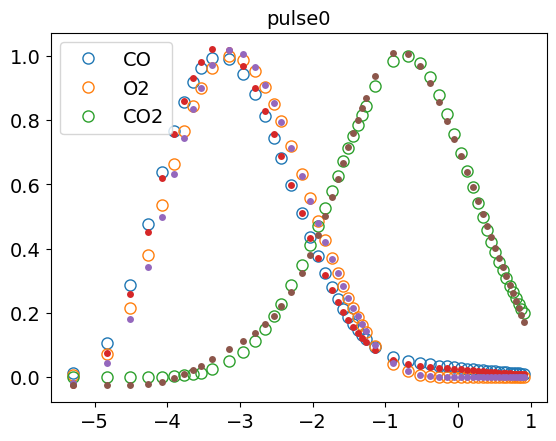

In [378]:
for n in range(len(pulse_train)):
    plt.figure()
    plt.plot(conc_inv[1][::3,0], conc_inv[0][::3,0:3], 'o', markerfacecolor='None', ms = 8)
    plt.legend(['CO', 'O2', 'CO2'])
    plt.title('pulse' + str(pulse_train[n]))
    lines2a = plt.plot(t_train[::3],batched_state(nn_params_inv, t_train)[::3,0:3],'o',\
                      ms=5,markeredgecolor='none')

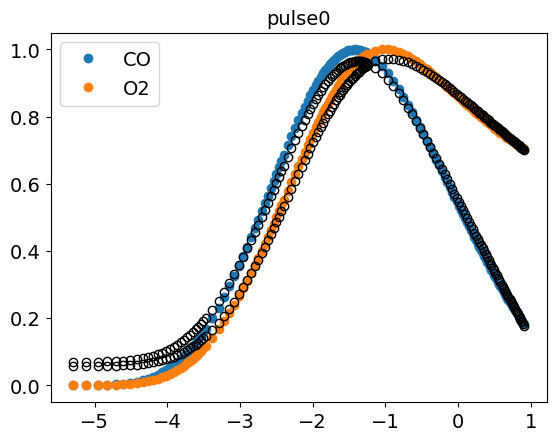

In [375]:
for n in range(len(pulse_train)):
    plt.figure()
    plt.plot(conc_inv[1][:,0], conc_inv[0][:,3:5], 'o')
    plt.legend(['CO', 'O2', 'CO2'])
    plt.title('pulse' + str(pulse_train[n]))
    lines2a = plt.plot(t_train[:],batched_state(nn_params_inv, t_train)[:,3:5],'o',\
                      ms=6,markerfacecolor='None',markeredgecolor='black')

## Uncertainty through inverse hessian

In [230]:
def error_wrt_params(p):
    alpha_factor = np.array([[1e6], [9e2]])
    return (np.array(errors_inv([nn_params, p], conc_inv, net_flux_train))/alpha_factor).mean()
# error_wrt_params = lambda p: (errors_inv([nn_params, p], conc_inv, net_flux_train)[-1]/1e3).mean()
hessian_func = jit(hessian(error_wrt_params))

# Assuming 'model_params' holds the value of the parameters at the optimum,
# calculate the Hessian matrix
hessian_matrix = hessian_func(model_params)

# # Inverting the Hessian gives us the covariance matrix
covariance_matrix = np.linalg.inv(np.array(hessian_matrix))[0][0]

# # The standard deviations are the square roots of the diagonal elements of the covariance matrix
standard_deviations = np.sqrt(np.diag(covariance_matrix))

standard_deviations

Array([0.09068231, 0.04753053, 0.00266227, 0.02894975, 0.00988475,
       1.2506179 ], dtype=float64)

## Reconstruct TAP response curve by solving the ODE using predicted parameter value

In [11]:
def model_ode(t, x, k, flux, time_points):

    # Interpolate the flux values at the current time t
    flux_interp = interp1d(time_points, flux, axis=1, fill_value = 'extrapolate')
    current_flux = flux_interp(t).reshape(6, 1)
    x = x*y_train_scale
    dCdt = np.array([[-k[0]*x[0]*x[5] + k[1]*x[3] - k[5]*x[0]*x[4]],
                    [-k[2]*x[1]*x[5]**2],
                    [k[3]*x[3]*x[4] - k[4]*x[2]*x[5]**2 + k[5]*x[0]*x[4]],
                    [k[0]*x[0]*x[5] - k[1]*x[3] - k[3]*x[3]*x[4] + k[4]*x[2]*x[5]**2],
                    [(k[2]*x[1]*x[5]**2)*2 - k[3]*x[3]*x[4] + k[4]*x[2]*x[5]**2 - k[5]*x[0]*x[4]],
                    [-k[0]*x[0]*x[5] + k[1]*x[3] - (k[2]*x[1]*x[5]**2)*2 + k[3]*x[3]*x[4]*2 - 2*k[4]*x[2]*x[5]**2 + k[5]*x[0]*x[4]]]) + current_flux
    dCdt = dCdt.T/y_train_scale
    return dCdt.flatten()

# Define the time span over which to solve the ODEs
t_span = (0.0, 2.5) 

# Define the initial conditions for x
x0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 1.0])

# Define the model parameters k and flux
k = np.abs(np.array([-11.52271015,  -0.52831707,  -0.25274057,   0.36894424,
        -0.03216084,  12.76715619]))  # predicted k
k_true = np.array([15, 0.7, 0.33, 0.4, 0.02, 15.2])  # actual k
flux = net_flux_train.T

# Define the time points corresponding to the flux matrix
time_points_flux = np.exp(t_train).flatten()

ode_func = lambda t, x: model_ode(t, x, k, flux, time_points_flux)
ode_true = lambda t, x: model_ode(t, x, k_true, flux, time_points_flux)

# Solve the ODEs
solution = solve_ivp(ode_func, t_span, x0, t_eval=time_points_flux, method = 'LSODA')
solution_true = solve_ivp(ode_true, t_span, x0, t_eval=time_points_flux)

# # Extract the solution
time_points = solution.t
x_solution = np.abs(solution.y)

time_true = solution_true.t
x_true = np.abs(solution_true.y)

/var/tmp/pbs.1634647.sawtoothpbs/ipykernel_83946/823239617.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


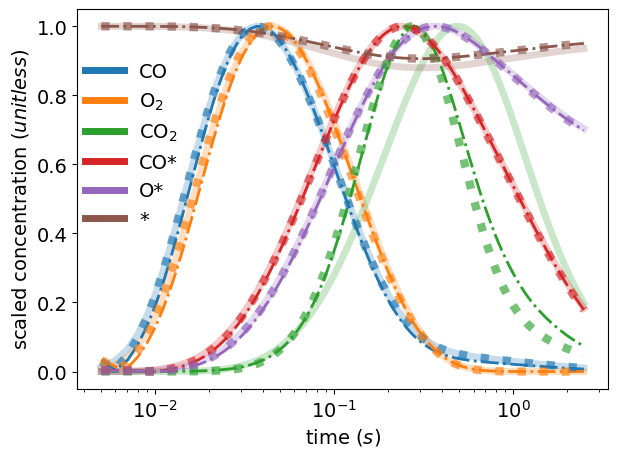

In [16]:
fig, axs = plt.subplots(tight_layout = True)

axs.plot(np.exp(t_train),(conc_inv[0])[:,:], '-', linewidth = 5.0, alpha = 0.25, markeredgecolor='none')
axs.set_prop_cycle(None)
axs.plot(solution.t, x_solution.T/np.max(x_solution, axis = 1), '-.', linewidth = 2.0)
axs.set_prop_cycle(None)
axs.plot(solution_true.t, x_true.T/np.max(x_true, axis = 1), linestyle=':', linewidth = 6.0, alpha = 0.65)

axs.set_xscale('log')
axs.set_xlabel('time $(s)$')
axs.set_ylabel('scaled concentration $(unitless)$')

leg = axs.legend(['CO', 'O$_2$', 'CO$_2$', 'CO*', 'O*', '*'], ncol = 1, frameon = False, loc = [0, 0.4])
for lh in leg.legendHandles: 
    lh.set_alpha(1)

## Visualize performance

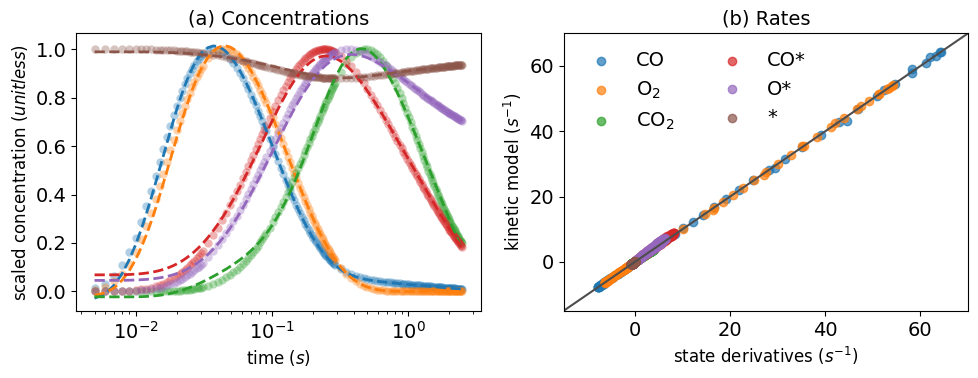

In [232]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4), tight_layout = True)

axs[0].plot(np.exp(conc_inv[1][::,0]), conc_inv[0][::,0:], 'o', markeredgecolor='none', ms = 6, alpha = 0.35)
axs[0].set_prop_cycle(None)
axs[0].plot(np.exp(t_train[:]), batched_state(nn_params_inv, t_train)[:,0:],'--',\
                      linewidth = 2,markeredgecolor='none')
axs[0].set_title('(a) Concentrations')
axs[0].set_xlabel('time ($s$)', fontsize = 12)
axs[0].set_ylabel('scaled concentration ($unitless$)', fontsize = 12)
axs[0].set_xscale('log')

for i in range(6):
    axs[1].scatter(model_pred[:,i], model_diff[:,i],
               color = 'C{}'.format(i), alpha = 0.7)
axs[1].set(xlim=(-15, 70), ylim=(-15, 70))
axs[1].plot(axs[1].get_xlim(), axs[1].get_ylim(), ls="-", c = '.3')
axs[1].set_xlabel('state derivatives ($s^{-1}$)', fontsize = 12)
axs[1].set_ylabel('kinetic model ($s^{-1}$)', fontsize = 12)
axs[1].set_title('(b) Rates')

axs[1].legend(['CO', 'O$_2$', 'CO$_2$', 'CO*', 'O*', '*'], ncol = 2, frameon = False)

In [3]:
np.savez('./results/single_ideal', data = {'nn_params' :nn_params_data, 'model_params': model_params})